# PyTorch EO Semantic Segmentation Example
## Step 5: Model Inference
*Rob Knapen, Wageningen Environmental Research*
<br>

This notebook provides an example of using a trained model that has been converted to TorchScript for inference, taking a geotiff file as input. GDAL is used to read and write geotiff files, since we want to be able to convert the method to C++ in the end.

In [53]:
import torch
from osgeo import gdal

import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

%matplotlib inline

In [54]:
# files to processing

# torchscript trained model to use for inference
model_file = "../models/rvo_crops_segnet_224x224x28_77classes_100epochs_model_full_traced.pt"

# input file, should match model dimensions and data pre-processing
input_file = "../data/raw/sentinel2_2018_flevopolder_10m_7x4bands.tif"

In [55]:
# load the torchscript model
model = torch.jit.load(model_file)
print(model)

RecursiveScriptModule(
  original_name=SegNet
  (maxpool): RecursiveScriptModule(original_name=MaxPool2d)
  (unpool): RecursiveScriptModule(original_name=MaxUnpool2d)
  (c1): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Conv2d)
    (1): RecursiveScriptModule(original_name=BatchNorm2d)
    (2): RecursiveScriptModule(original_name=ReLU)
  )
  (c2): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Conv2d)
    (1): RecursiveScriptModule(original_name=BatchNorm2d)
    (2): RecursiveScriptModule(original_name=ReLU)
  )
  (c3): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Conv2d)
    (1): RecursiveScriptModule(original_name=BatchNorm2d)
    (2): RecursiveScriptModule(original_name=ReLU)
  )
  (c4): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Conv2d)
    (1): RecursiveScriptModule(original_na

In [56]:
# visualise the input file using rasterio
input_ds = rasterio.open(input_file)

print('Input image width   :', input_ds.width)
print('Input image height  :', input_ds.height)
print('Input image bounds  :', input_ds.bounds)
print('Input image indexes :', input_ds.indexes)
print('Input dataset shape :', input_ds.read().shape)

Input image width   : 5490
Input image height  : 2170
Input image bounds  : BoundingBox(left=674900.0, bottom=5832260.0, right=729800.0, top=5853960.0)
Input image indexes : (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28)
Input dataset shape : (28, 2170, 5490)


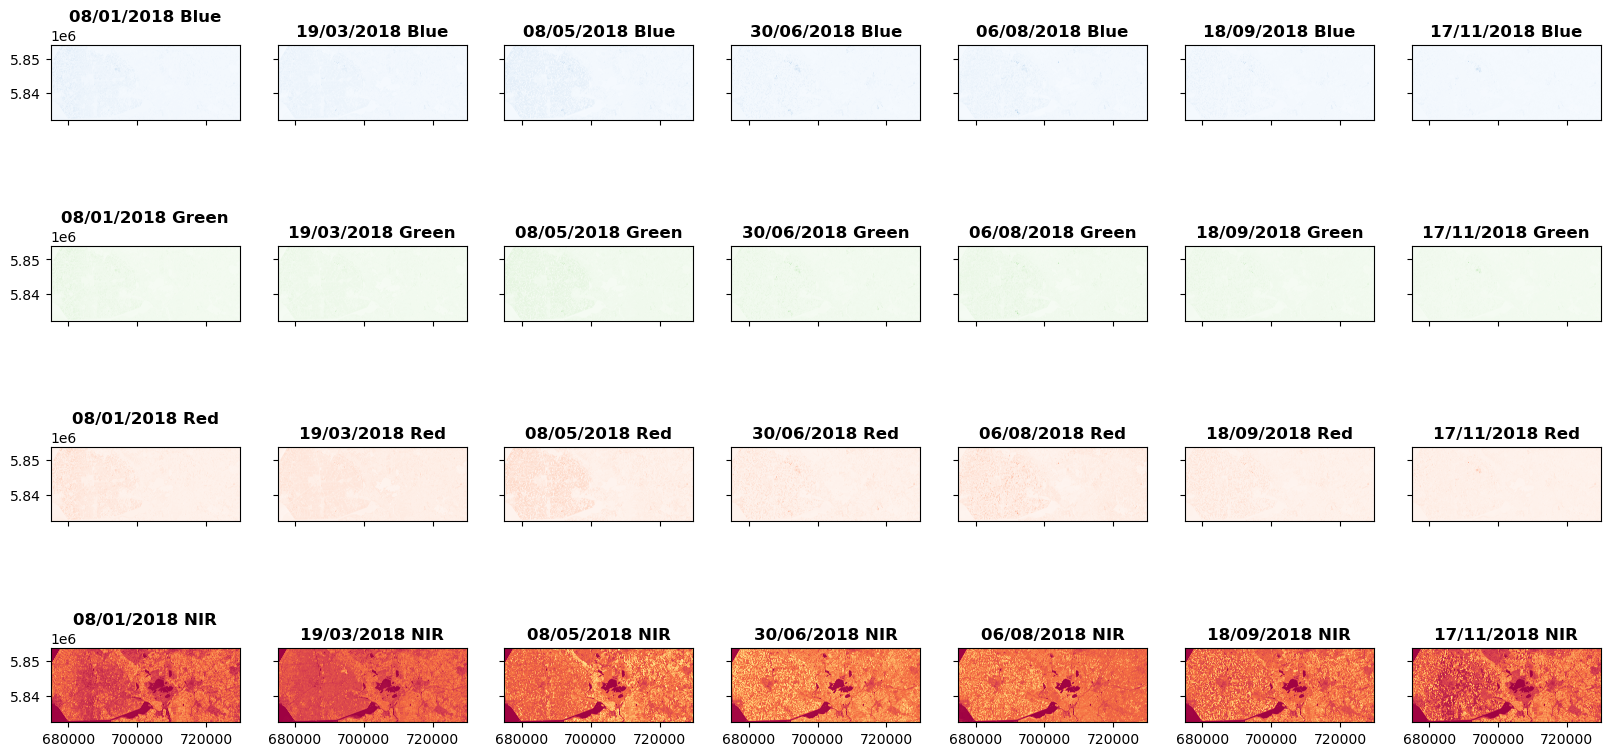

In [57]:
fig, ax = plt.subplots(4, 7, sharex='col', sharey='row', figsize=(20,10))

dates = ['08/01/2018', '19/03/2018', '08/05/2018', '30/06/2018', '06/08/2018', '18/09/2018', '17/11/2018']

for i in range(len(dates)):
    show((input_ds, (i*4)+1), ax=ax[0, i], cmap='Blues', title='%s Blue' % dates[i])
    show((input_ds, (i*4)+2), ax=ax[1, i], cmap='Greens', title='%s Green' % dates[i])
    show((input_ds, (i*4)+3), ax=ax[2, i], cmap='Reds', title='%s Red' % dates[i])
    show((input_ds, (i*4)+4), ax=ax[3, i], cmap='Spectral', title='%s NIR' % dates[i])

In [58]:
# try to open the input file with gdal
dataset = gdal.Open(input_file)
if not dataset:
    print("could not read the file")

In [59]:
# get some information from the file
print("Driver: {}/{}".format(dataset.GetDriver().ShortName, dataset.GetDriver().LongName))
print("Size is {} x {} x {}".format(dataset.RasterXSize, dataset.RasterYSize, dataset.RasterCount))
print("Projection is {}".format(dataset.GetProjection()))
geotransform = dataset.GetGeoTransform()
if geotransform:
    print("Origin = ({}, {})".format(geotransform[0], geotransform[3]))
    print("Pixel Size = ({}, {})".format(geotransform[1], geotransform[5]))

Driver: GTiff/GeoTIFF
Size is 5490 x 2170 x 28
Projection is PROJCS["WGS 84 / UTM zone 31N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",3],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32631"]]
Origin = (674900.0, 5853960.0)
Pixel Size = (10.0, -10.0)


In [60]:
# get some raster band information
band = dataset.GetRasterBand(1)
print("Band Type={}".format(gdal.GetDataTypeName(band.DataType)))

min = band.GetMinimum()
max = band.GetMaximum()
if not min or not max:
    (min,max) = band.ComputeRasterMinMax(True)
print("Min={:.3f}, Max={:.3f}".format(min,max))

if band.GetOverviewCount() > 0:
    print("Band has {} overviews".format(band.GetOverviewCount()))

if band.GetRasterColorTable():
    print("Band has a color table with {} entries".format(band.GetRasterColorTable().GetCount()))

Band Type=UInt16
Min=1.000, Max=7267.000


In [67]:
# read multiple bands from the dataset into a numpy array
arr = dataset.ReadAsArray(
    xoff=0,
    yoff=0,
    xsize=2000,
    ysize=1000,
    buf_obj=None,
    buf_xsize=None,
    buf_ysize=None,
    buf_type=None,
    resample_alg=0,
    callback=None,
    callback_data=None,
    interleave='band',
    band_list=None
).astype("float32")

arr.shape

(28, 1000, 2000)

In [68]:
# normalize the band data before the inference
def normalize(ds, tile_np):
    for index in range(tile_np.shape[0]):
        band = ds.GetRasterBand(index + 1)
        (_, b_max) = band.ComputeRasterMinMax(True)
        tile_np[index] /= b_max

normalize(dataset, arr)
arr

array([[[0.05793312, 0.05242879, 0.04541076, ..., 0.06385028,
         0.07114352, 0.08531719],
        [0.06385028, 0.05242879, 0.04843815, ..., 0.05352965,
         0.06467593, 0.07196917],
        [0.05600661, 0.05463052, 0.05875877, ..., 0.04169533,
         0.05215357, 0.06467593],
        ...,
        [0.03839273, 0.04348424, 0.04596119, ..., 0.0476125 ,
         0.04031925, 0.04953901],
        [0.04375946, 0.0477501 , 0.04018164, ..., 0.03660383,
         0.04059447, 0.04719967],
        [0.04004404, 0.03935599, 0.04018164, ..., 0.04031925,
         0.04059447, 0.03825513]],

       [[0.05174787, 0.05463804, 0.05257363, ..., 0.08009909,
         0.09152216, 0.10597303],
        [0.05174787, 0.05463804, 0.05381228, ..., 0.07390586,
         0.08725571, 0.09922928],
        [0.05587669, 0.05284889, 0.05147261, ..., 0.07652078,
         0.08078723, 0.08078723],
        ...,
        [0.02422241, 0.02188274, 0.02243325, ..., 0.05298651,
         0.0494082 , 0.04995871],
        [0.0

In [69]:
# re-order the dimensions (if needed) and add a batch dimension
tile = arr.transpose(0,1,2)
tile_t = torch.from_numpy(tile).unsqueeze(dim=0)
tile_t.shape

torch.Size([1, 28, 1000, 2000])

In [70]:
# infer the output, take the max, and remove the batch dimension
model.eval()
pred = model(tile_t).argmax(1).squeeze()

# the predicted crop class per cell
pred

tensor([[ 6,  6,  6,  ...,  1,  1,  1],
        [ 6,  6,  6,  ...,  1,  1,  1],
        [ 6,  6,  8,  ...,  1,  1,  1],
        ...,
        [21, 21, 21,  ...,  2,  2,  2],
        [21, 21, 21,  ...,  2,  2,  2],
        [21, 21, 21,  ...,  2,  2,  2]])

In [71]:
pred.shape

torch.Size([1000, 2000])

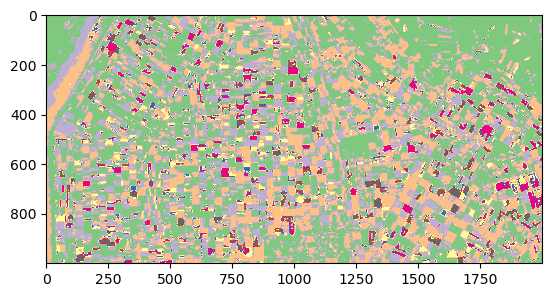

In [72]:
# display as image (set the legend for the crop classes)
# note that the model is not very good at creating nice parcel boundaries ...
# and it would be better to use a custom colour map for the 76 crop classes
plt.imshow(pred, cmap="Accent")

In [ ]:
# TODO
#   - loop over tiles to predict full image
#   - write full result to geotiff file with correct CRS